# Catan Board Generation

## Todo
- [x] Move to notebooks
- [x] Create git repo
- [x] Install git notebook extensions https://coderefinery.github.io/jupyter/version-control/
- [x] Play around with SVG library to see if it would be better https://pypi.org/project/drawSvg/
- [ ] Refactor code so that it uses a hexagonal co-ordinate system https://www.redblobgames.com/grids/hexagons/#hex-to-pixel
- [ ] Think about metrics
- [ ] Calculate number of possible boards
- [ ] Use git

In [1]:
from math import sqrt, sin, cos, pi
import os
from random import randint, shuffle, seed

seed(2022)

In [18]:
class Point:
    """
    Defines 2D points.
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.tuple = (x, y)

    def __str__(self):
        rounded_x = round(self.x, 3)
        rounded_y = round(self.y, 3)
        return f"{rounded_x}, {rounded_y}"

    def __repr__(self):
        return str(self)
    

def rotate(point, angle, origin=Point(0, 0)):
    """
    Rotates a point by a given angle (in radians) around a specified point.
    :param point: The point to be rotated.
    :param angle: The angle (in radians) to rotate the point by.
    :param origin: The point by which to rotate around.
    :return:
    """
    p = point
    o = origin
    a = angle
    del_x = p.x - o.x
    del_y = p.y - o.y
    x = o.x + del_x * cos(a) - del_y * sin(a)
    y = o.y + del_x * sin(a) + del_y * cos(a)
    return Point(x, y)

class Hexagon:
    """
    Defines a regular, six sided polygon (a hexagon) by taking a central point
    and side length.
    """
    def __init__(self, center=Point(0, 0), side_length=1, id=None):
        self.center = center
        self.length = side_length
        self.vertices = self._calc_vertices_()
        self.id = id

    def __str__(self):
        return f"Regular hexagon with center " \
               f"at {self.center} and side lengths {self.length}"

    def __repr__(self):
        return str(self)

    def _get_hex_width_(self):
        """
        Calculate the width (distance between parallel sides) of the hexagon
        :return: Hexagon width
        """
        return self.length * sqrt(3)

    def _calc_vertices_(self):
        """
        Calculates the cartesian co-ordinates of the vertices of the hexagon
        :return: List of points, each representing a vertex of the hexagon
        """
        # Vertices of a hexagon are generated by successively rotating one
        # vertex by 60 degrees.
        p1 = Point(self.center.x, self.center.y + self.length)
        angles = [pi/3 * x for x in range(6)]
        points = [rotate(p1, angle, self.center) for angle in angles]
        return points


class Hex(Hexagon):
    """
    Builds on the Hexagon class to create Catan like hexes.
    """
    def __init__(self, center=Point(0, 0), side_length=1, id=None, land_type=None, token=None):
        super().__init__(center, side_length, id)
        self.land_type = land_type
        self.token = token
        
# Point class causes issues with SVG library
def points_to_coordinate_list(hex): 
    """
    Converts the co-ordinates of the vertices of a hex into a list of floats.
    """
    points = [vertex.tuple for vertex in hex.vertices]
    coordinates = [coord for tup in points for coord in tup]
    return coordinates
        
def generate_hex_lines(num_tiles, length, gap, y=0):
    """
    Generates a collection of hexagons all on the same horizontal line
    :param num_tiles: Number of hexagons to create
    :param length: Side length of the hexagons
    :param gap: Gap between hexagons
    :return: a list of hexagons
    """
    w = length * sqrt(3)
    # Generate x co-ordinates for the centres of the hexagons
    if num_tiles % 2 == 0:
        x = [(gap / 2 + w/2) + n * (w + gap) for n in range(num_tiles//2)]
        neg_x = [-e for e in x]
        neg_x.sort()
        x_coords = [*neg_x, *x]
    else:
        x = [n * (w + gap) for n in range(num_tiles//2 + 1)]
        neg_x = [-e for e in x[1:]]
        neg_x.sort()
        x_coords = [*neg_x, *x]

    hexes = []

    for x in x_coords:
        hex = Hex(Point(x, y), length)
        hexes.append(hex)

    return hexes


def create_board_tiles(side_length, gap):
    line1 = generate_hex_lines(3, side_length, gap, -3 * side_length - 2 * gap)
    line2 = generate_hex_lines(4, side_length, gap, -3 / 2 * side_length - gap)
    line3 = generate_hex_lines(5, side_length, gap, 0)
    line4 = generate_hex_lines(4, side_length, gap, 3 / 2 * side_length + gap)
    line5 = generate_hex_lines(3, side_length, gap, 3 * side_length + 2 * gap)
    hexes = [*line1, *line2, *line3, *line4, *line5]

    hexes_available = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5]
    tokens_available = [2, 3, 3, 4, 4, 5, 5, 6, 6, 8, 8, 9 ,9, 10, 10, 11, 11, 12]
    shuffle(hexes_available)
    shuffle(tokens_available)

    for i in range(len(hexes)):
        hexes[i].id = i + 1
        hexes[i].land_type = hexes_available.pop()
        if hexes[i].land_type != 5:
            hexes[i].token = tokens_available.pop()

    return(hexes)


def write_board(hexes, width, height):
    resource_keys = {
        0: 'wool',
        1: 'grain',
        2: 'lumber',
        3: 'brick',
        4: 'ore',
        5: 'desert'
    }

    hex_colours = {
        0: '#a7c957',
        1: '#DFB853',
        2: '#20703D',
        3: '#C37C3A',
        4: '#737373',
        5: '#DCBB96'
    }


    hex_svg = ''
    for hex in hexes:
        # print(hex)
        vertices = ''
        for vertex in hex.vertices:
            vertices += f"{vertex.x + width / 2},{vertex.y + height / 2} "
        
        hex_str = f"""<polygon id="svg_{hex.id}" shape="regularPoly" sides="6" orient="x" points="{vertices}" fill="{hex_colours[hex.land_type]}" 
     stroke="black" stroke-width="3" transform="rotate(60, {hex.center.x + width / 2}, {hex.center.y + height / 2})"/>\n"""
        if hex.land_type != 5:
            if hex.token == 6 or hex.token == 8:
                token_color = "#E20303"
            else:
                token_color = "#000000"
            font_size = 31 - 3 * abs(7 - hex.token)
            hex_str += f"""<circle cx="{hex.center.x + width / 2}" cy="{hex.center.y + height / 2}" r="20" fill="#FFEDD0"/>
    <text font-family="Open Sans" x="{hex.center.x + width / 2}" y="{hex.center.y + height / 2}" text-anchor="middle" dominant-baseline="central" fill="{token_color}" font-size="{font_size}">{hex.token}</text>"""
        
        hex_svg += hex_str

        
    # print(hex_svg)
    board = f"""<?xml version="1.0"?>
    <svg width="{width}" height="{height}" xmlns="http://www.w3.org/2000/svg" xmlns:svg="http://www.w3.org/2000/svg">
    {hex_svg}
    </svg>
    """

    os.chdir('/home/lo/Desktop')
    board_svg = open("board.svg", "w")
    board_svg.write(board)
    board_svg.close()


In [3]:
width, height = 500, 500
hexes = create_board_tiles(50, 0)
write_board(hexes, width, height)

![](board.svg)

In [34]:
import drawSvg as draw

In [51]:
def write_board2(hexes, width, height):
    resource_keys = {
        0: 'wool',
        1: 'grain',
        2: 'lumber',
        3: 'brick',
        4: 'ore',
        5: 'desert'
    }

    hex_colours = {
        0: '#a7c957',
        1: '#DFB853',
        2: '#20703D',
        3: '#C37C3A',
        4: '#737373',
        5: '#DCBB96'
    }

    d = draw.Drawing(width, height, origin='center')

    for hex in hexes:
        d.append(draw.Lines(*points_to_coordinate_list(hex),close=True,
                            fill=hex_colours[hex.land_type],
                            stroke='black', stroke_width=3))

        if hex.land_type != 5:
            if hex.token == 6 or hex.token == 8:
                token_color = "#E20303"
            else:
                token_color = "#000000"
            font_size = 31 - 2.5 * abs(7 - hex.token)

            d.append(draw.Circle(hex.center.x, hex.center.y, 
                                 r=20, fill="#FFEDD0"))
            
            d.append(draw.Text(str(hex.token), fontSize=font_size, 
                               x=hex.center.x, y=hex.center.y, center=True, 
                               valign = 'middle', font_family = "Open Sans", 
                               fill = token_color))
    return(d)

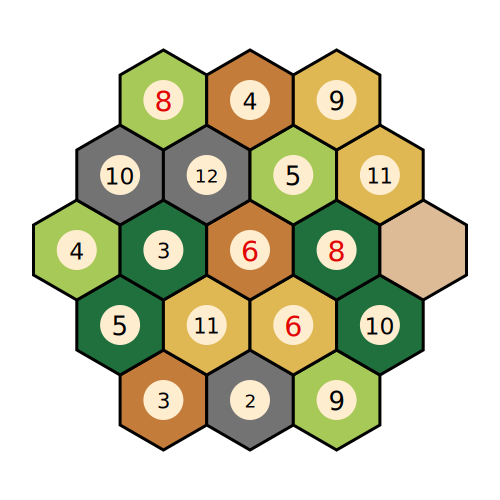

In [70]:
hexes = create_board_tiles(50, 0)
write_board2(hexes, width, height)